# ML Model for Transport Risk Mitigation  

The objective is to develop ML models using the provided dataset, to predict potentially dangerous temperature and humidity conditions while transporting high-value goods, including livestock and perishable food items. By analyzing telematics, weather data, and sensor readings, the model will uncover the influence of external weather, geolocation, and internal microclimate on transport conditions.  

The primary goal is to forecast instances where temperatures may exceed 25°C and/or humidity levels may surpass 80%.  

Data source : https://drive.google.com/drive/folders/1_-Eh_BXhjSkKtJ-s1rrMXxsE9Z6EfteN  


- Analytics
  - Find correlations between geolocation, external weather, timestamp, and internal microclimate data. How are these pillars interconnected?
  - How does this interconnectedness influence the risk of dangerous temperatures or humidity?
  - How do specific weather events (like high winds) or variables such as the proximity of farms to roads contribute to temperature risk?
  - How can the risk of temperature or humidity-related issues be minimized for long-distance transportation events?
  - What combination of internal and external weather factors conclude an ideal temperature that is less than 25 degree celsius and less than 80% humidity?

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime

# Third Party
import pandas as pd
import numpy as np


# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# Definitions

In [2]:
PATH_DATA = "data"
path_data = os.path.join(PATH_DATA, "inner.csv")

# Load Data

In [3]:
# load
df_raw = pd.read_csv(path_data)
df_raw

,pkId,fkLinkSerialId,timestamp,speed,acceleration,heading,direction,msla,lat,long,...,place,region,locality,neighborhood,postcode,country,fkReadingsId,fkSensorSerialId,measurement,value
0,2595655,0X0004BFD0379C,2022-05-07 07:40:48,0,1,0,N,48,-33.226616,150.961105,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595655,0XC07A1A,temperature,17.17
1,2595655,0X0004BFD0379C,2022-05-07 07:40:48,0,1,0,N,48,-33.226616,150.961105,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595655,0XC07A1A,humidity,45.44
2,2595657,0X0004BFD0379C,2022-05-07 07:41:24,0,1,0,N,28,-33.226601,150.961136,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595657,0XC07BAE,temperature,17.55
3,2595657,0X0004BFD0379C,2022-05-07 07:41:24,0,1,0,N,28,-33.226601,150.961136,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595657,0XC07BAE,humidity,44.66
4,2595665,0X0004BFD0379C,2022-05-07 07:43:49,0,1,0,N,73,-33.226665,150.961136,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595665,0XC07A1A,temperature,17.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405167,3590705,0XB827EB3B7400,2023-04-21 15:57:34,0,1,0,N,362,43.481396,-81.068588,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590705,0XC08294,humidity,99.99
405168,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC0794D,temperature,11.47
405169,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC0794D,humidity,99.99
405170,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC079D9,temperature,11.42


## Missing values

In [4]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_raw)

missing data : 
region            3452
value             4761
place            26432
accuracy         26484
postcode         26690
wind_gust        79564
neighborhood    363660
locality        378704
snow            384626
rain            384844
uvi             405172
dew_point       405172
dtype: int64

on 405172 samples


In [11]:
list_all_nan = nb_missing.index[nb_missing.values == df_raw.shape[0]].to_list()
print(list_all_nan)
df = df_raw.drop(columns=list_all_nan).copy()
df

['uvi', 'dew_point']


,pkId,fkLinkSerialId,timestamp,speed,acceleration,heading,direction,msla,lat,long,...,place,region,locality,neighborhood,postcode,country,fkReadingsId,fkSensorSerialId,measurement,value
0,2595655,0X0004BFD0379C,2022-05-07 07:40:48,0,1,0,N,48,-33.226616,150.961105,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595655,0XC07A1A,temperature,17.17
1,2595655,0X0004BFD0379C,2022-05-07 07:40:48,0,1,0,N,48,-33.226616,150.961105,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595655,0XC07A1A,humidity,45.44
2,2595657,0X0004BFD0379C,2022-05-07 07:41:24,0,1,0,N,28,-33.226601,150.961136,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595657,0XC07BAE,temperature,17.55
3,2595657,0X0004BFD0379C,2022-05-07 07:41:24,0,1,0,N,28,-33.226601,150.961136,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595657,0XC07BAE,humidity,44.66
4,2595665,0X0004BFD0379C,2022-05-07 07:43:49,0,1,0,N,73,-33.226665,150.961136,...,NaN,AU-NSW,NaN,NaN,NaN,au,2595665,0XC07A1A,temperature,17.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405167,3590705,0XB827EB3B7400,2023-04-21 15:57:34,0,1,0,N,362,43.481396,-81.068588,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590705,0XC08294,humidity,99.99
405168,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC0794D,temperature,11.47
405169,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC0794D,humidity,99.99
405170,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC079D9,temperature,11.42


# Data structure

Nb vehicules

In [57]:
df["fkLinkSerialId"].nunique()

9

<AxesSubplot: xlabel='count', ylabel='fkLinkSerialId'>

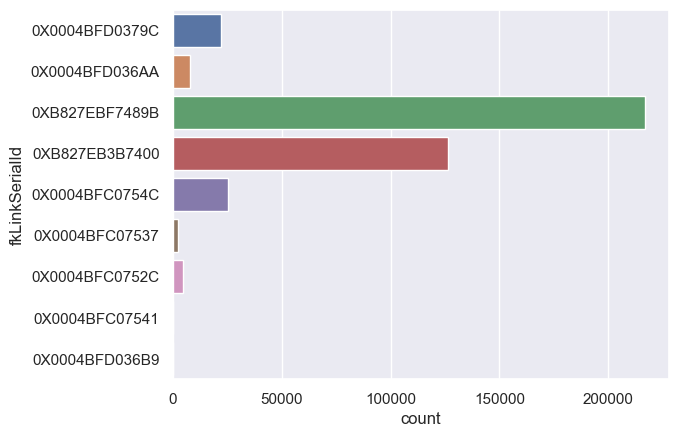

In [58]:
sns.countplot(data=df, y="fkLinkSerialId")

In [54]:
df["pkId"].nunique()

124249

In [84]:
db_nb_data = df[["timestamp", "pkId"]].groupby(["pkId"]).count()
db_nb_data

,timestamp
pkId,
2595655,2
2595657,2
2595665,2
2595667,2
2595675,2
...,...
3590602,4
3590619,6
3590636,2


In [55]:
df.shape[0]

405172

In [72]:
db_nb_data.describe()

,timestamp
count,124249.000000
mean,3.260968
std,2.215288
min,2.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,14.000000


In [73]:
db_nb_data[db_nb_data["timestamp"] == 14]

,timestamp
pkId,
2606172,14
2606226,14
2606277,14
2606490,14
2606647,14
...,...
3233789,14
3235199,14
3245579,14


In [76]:
df[df["pkId"] == 2606172]

,pkId,fkLinkSerialId,timestamp,speed,acceleration,heading,direction,msla,lat,long,...,place,region,locality,neighborhood,postcode,country,fkReadingsId,fkSensorSerialId,measurement,value
4248,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07745,temperature,16.24
4249,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07745,humidity,30.78
4250,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07A39,temperature,16.04
4251,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07A39,humidity,30.59
4252,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07A5C,temperature,15.96
4253,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07A5C,humidity,31.61
4254,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07B5E,temperature,16.09
4255,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07B5E,humidity,30.26
4256,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07B98,temperature,16.33
4257,2606172,0XB827EBF7489B,2022-05-09 08:02:52,0,1,0,N,365,43.604435,-80.308678,...,Guelph/Eramosa,CA-ON,NaN,NaN,N1H 6J2,ca,2606172,0XC07B98,humidity,30.48


In [69]:
db_nb_data["timestamp"].max()

14

In [70]:
db_nb_data["timestamp"].min()

2

In [87]:
#def fun_diff(list_in):
#    return  np.all(np.array(list_in ) == list_in[0])

db_nb_readings = df[["fkReadingsId", "pkId"]].groupby(["pkId"]).nunique()
db_nb_readings.describe()

,fkReadingsId
count,124249.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


=> Each fkReadingsId is linked with one pkId

We can aggregate sensors in the vehicle.  
=> Create : mean / max / min value  for T°C and Humidity %

In [88]:
df_temp = df[df["measurement"] == "temperature"].copy()
print(df_temp.shape)
df_humi = df[df["measurement"] == "humidity"].copy()
print(df_humi.shape)

(202586, 41)
(202586, 41)


In [95]:
df_temp_agg =  df_temp.groupby(["fkReadingsId"]).agg(
    temp_mean = ("value", "mean"),
    temp_min = ("value", "min"),
    temp_max = ("value", "max"),
)
df_temp_agg

,temp_mean,temp_min,temp_max
fkReadingsId,,,
2595655,17.170,17.17,17.17
2595657,17.550,17.55,17.55
2595665,17.090,17.09,17.09
2595667,17.480,17.48,17.48
2595675,18.550,18.55,18.55
...,...,...,...
3590602,12.000,11.84,12.16
3590619,12.090,11.74,12.44
3590636,12.010,12.01,12.01


In [96]:
df_humi_agg =  df_humi.groupby(["fkReadingsId"]).agg(
    humi_mean = ("value", "mean"),
    humi_min = ("value", "min"),
    humi_max = ("value", "max"),
)
df_humi_agg

,humi_mean,humi_min,humi_max
fkReadingsId,,,
2595655,45.44,45.44,45.44
2595657,44.66,44.66,44.66
2595665,45.53,45.53,45.53
2595667,44.74,44.74,44.74
2595675,45.62,45.62,45.62
...,...,...,...
3590602,97.63,95.27,99.99
3590619,98.53,95.61,99.99
3590636,99.99,99.99,99.99


In [97]:
df[df["fkReadingsId"] == 3590722 ]

,pkId,fkLinkSerialId,timestamp,speed,acceleration,heading,direction,msla,lat,long,...,place,region,locality,neighborhood,postcode,country,fkReadingsId,fkSensorSerialId,measurement,value
405168,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC0794D,temperature,11.47
405169,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC0794D,humidity,99.99
405170,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC079D9,temperature,11.42
405171,3590722,0XB827EB3B7400,2023-04-21 16:00:29,0,1,0,N,355,43.481373,-81.068619,...,Sebringville,CA-ON,NaN,NaN,N0K 1X0,ca,3590722,0XC079D9,humidity,99.99


# Countries

# Time

In [43]:
df[["timestamp", "tsReceived", "dt","sunrise", "sunset", "region", "country" ]]

,timestamp,tsReceived,dt,sunrise,sunset,region,country
0,2022-05-07 07:40:48,2022-05-07 07:40:48,2022-05-07 07:40:48,2022-05-06 16:33:48,2022-05-07 03:11:39,AU-NSW,au
1,2022-05-07 07:40:48,2022-05-07 07:40:48,2022-05-07 07:40:48,2022-05-06 16:33:48,2022-05-07 03:11:39,AU-NSW,au
2,2022-05-07 07:41:24,2022-05-07 07:41:24,2022-05-07 07:40:48,2022-05-06 16:33:48,2022-05-07 03:11:39,AU-NSW,au
3,2022-05-07 07:41:24,2022-05-07 07:41:24,2022-05-07 07:40:48,2022-05-06 16:33:48,2022-05-07 03:11:39,AU-NSW,au
4,2022-05-07 07:43:49,2022-05-07 07:43:49,2022-05-07 07:40:48,2022-05-06 16:33:48,2022-05-07 03:11:39,AU-NSW,au
...,...,...,...,...,...,...,...
405167,2023-04-21 15:57:34,2023-04-21 15:57:34,2023-04-21 15:56:28,2023-04-21 06:32:12,2023-04-21 20:13:26,CA-ON,ca
405168,2023-04-21 16:00:29,2023-04-21 16:00:29,2023-04-21 15:56:28,2023-04-21 06:32:12,2023-04-21 20:13:26,CA-ON,ca
405169,2023-04-21 16:00:29,2023-04-21 16:00:29,2023-04-21 15:56:28,2023-04-21 06:32:12,2023-04-21 20:13:26,CA-ON,ca
405170,2023-04-21 16:00:29,2023-04-21 16:00:29,2023-04-21 15:56:28,2023-04-21 06:32:12,2023-04-21 20:13:26,CA-ON,ca


In [52]:
print(df[df["country"] == "au"]["sunrise"].astype(np.datetime64).dt.hour.max())
print(df[df["country"] == "au"]["sunrise"].astype(np.datetime64).dt.hour.min())

16
16


In [53]:
print(df[df["country"] == "au"]["sunset"].astype(np.datetime64).dt.hour.max())
print(df[df["country"] == "au"]["sunset"].astype(np.datetime64).dt.hour.min())

3
2


In [46]:
df[df["country"] == "au"]["sunrise"].max()

'2022-05-29 16:49:49'

## Location

In [20]:
df["country"].unique()

array(['au', 'ca', 'us', 'ie', 'dk'], dtype=object)

In [21]:
df["region"].unique()

array(['AU-NSW', 'CA-QC', 'CA-ON', 'US-NY', nan, 'US-PA', 'US-MI',
       'US-IN', 'US-IL', 'US-IA', 'US-VT', 'CA-NB', 'DK-83', 'DK-82',
       'US-MN'], dtype=object)

In [12]:
# locality : a lot of missing values
df["locality"].unique()

array([nan, 'Dundas', 'Flamborough', 'Morriston', 'Phillipsburg',
       'Ratzburg', 'Mennonite Corner', 'Amulree', 'Wartburg', 'Kinkora',
       'Lavoie', 'Appleby', 'Ancaster', 'Chameran', 'Zuber Corners',
       'Avonbank', 'Youngsville', 'Glanbrook', 'Lawrence Park',
       'Wesleyville', 'Northwest Harborcreek', 'Brooksdale', 'Fairview',
       'St. Pauls Station', 'Mount Pleasant', 'Willow Grove',
       'Wilmot Centre', 'Schindelsteddle', 'Indian Point', 'Stoney Creek',
       'Homer', 'Niagara', 'Manns Corner', 'Hartsville', 'Independence',
       'West Sparta', 'North Dansville', 'Perkinsville', 'Wallace',
       'Erwin', 'Gang Mills', 'Presho', 'Old Lycoming Township',
       'Kenilworth', 'North Coventry Township', 'West Pikeland Township',
       'South Whitehall Township', 'Upper Macungie Township',
       'Lower Macungie Township', 'Upper Milford Township',
       'Spinnerstown', 'Milford Township', 'Salford Township',
       'Franconia Township', 'Kulpsville', 'Towamenci

In [18]:
df["neighborhood"].unique()

array([nan, 'Montréal-Nord', 'Victoria North', 'Rivière-des-Prairies',
       'Anjou', 'Central Frederick', 'Auditorium', 'Southdale',
       'Forest Heights', 'Aldershot', 'Guelph', 'Cambrian Hills',
       'Centennial', 'River Flats', 'Briardean', 'Royal Oak', 'Parklawn',
       'Pioneer Tower East', 'Hidden Valley', 'Vanier', 'Rockway',
       'Alpine', 'Meinzinger Park - Lakeside', 'Laurentian West',
       'Lovell Industrial Park', 'Plains', 'Dynes', 'Longmoor',
       'Pinedale', 'Corporate', 'Palmer', 'Tyandaga', 'Laurentian Hills',
       'Mercier-Ouest', 'Quartier Fatima', 'Quartier Saint-Jude',
       'Northwest Industrial Area', 'Henderson - Sky Acres',
       'Braneida Industrial Park', 'Alberton North', "Duff's Corner",
       'Garner', 'Scenic Woods', 'Ainslie Wood West', 'Ainslie Wood East',
       'Westdale South', 'Dundurn', 'Tansley', 'Fabreville', 'Chomedey',
       'Bordeaux-Cartierville', 'Saint-Laurent', 'Côte-des-Neiges',
       'Notre-Dame-de-Grâce', 'Pointe Sai

In [23]:

df["place"].unique()

array([nan, 'Montréal', 'Guelph/Eramosa', 'Guelph', 'Saint-Valentin',
       'Lacolle', 'Champlain', 'Woolwich', 'Charlemagne', 'Breslau',
       'Kitchener', 'Montréal-Est', 'Wilmot', 'New Hamburg', 'Perth East',
       'Tavistock', 'Saint-Blaise-sur-Richelieu', 'Saint-Thomas',
       'Burlington', 'Hamilton', 'Millgrove', 'Freelton', 'Puslinch',
       'Cambridge', 'Sainte-Geneviève-de-Berthier', 'Saint-Cuthbert',
       'Saint-Barthélemy', 'Maskinongé', 'Trois-Rivières',
       'Saint-Étienne-des-Grès', 'Perth South', 'Joliette', 'Saint-Paul',
       'Saint-Bernard-de-Lacolle', 'Repentigny', 'Terrebonne',
       'Stratford', 'East Zorra-Tavistock', 'Longueuil', 'Brossard',
       'Carignan', 'Saint-Jean-sur-Richelieu', 'Saint-Alexandre',
       'Notre-Dame-de-Stanbridge', 'Mitchell', 'West Perth',
       'South Huron', 'Lucan Biddulph', 'North Middlesex',
       'Saint-Édouard', 'Saint-Michel', 'Sebringville', 'Sainte-Clotilde',
       'Saint-Chrysostome', 'Franklin', 'Saint-Antoine

In [25]:
df["place_name"].nunique()

10755

In [24]:
df["place_name"].unique()

array(['St Albans, New South Wales, Australia',
       '5727 Boulevard Industriel, Montréal, Quebec H1G 3J1, Canada',
       '5656 Highway 6, Guelph/Eramosa, Ontario N1H 6J2, Canada', ...,
       '4722 Line 42, Sebringville, Ontario N0K 1X0, Canada',
       '4793 Line 42, Sebringville, Ontario N0K 1X0, Canada',
       '5128 Line 42, Sebringville, Ontario N0K 1X0, Canada'],
      dtype=object)

In [27]:
df["place_type"].unique()

array(['locality', 'address', 'place', 'region', 'postcode'], dtype=object)

In [34]:
df[df["place_type"] == "place"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text" ]]

,country,place,place_name,region,locality,neighborhood,postcode,text
4934,ca,NaN,"Saint-Bernard-de-Lacolle, Quebec, Canada",CA-QC,NaN,NaN,NaN,Saint-Bernard-de-Lacolle
4935,ca,NaN,"Saint-Bernard-de-Lacolle, Quebec, Canada",CA-QC,NaN,NaN,NaN,Saint-Bernard-de-Lacolle
7770,ca,NaN,"Saint-Bernard-de-Lacolle, Quebec, Canada",CA-QC,NaN,NaN,NaN,Saint-Bernard-de-Lacolle
7771,ca,NaN,"Saint-Bernard-de-Lacolle, Quebec, Canada",CA-QC,NaN,NaN,NaN,Saint-Bernard-de-Lacolle
9832,ca,NaN,"Saint-Bernard-de-Lacolle, Quebec, Canada",CA-QC,NaN,NaN,NaN,Saint-Bernard-de-Lacolle
...,...,...,...,...,...,...,...,...
400439,ca,NaN,"Morpeth, Ontario, Canada",CA-ON,NaN,NaN,NaN,Morpeth
400440,ca,NaN,"Morpeth, Ontario, Canada",CA-ON,NaN,NaN,NaN,Morpeth
400441,ca,NaN,"Morpeth, Ontario, Canada",CA-ON,NaN,NaN,NaN,Morpeth
400442,ca,NaN,"Morpeth, Ontario, Canada",CA-ON,NaN,NaN,NaN,Morpeth


In [35]:
df[df["place_type"] == "address"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

,country,place,place_name,region,locality,neighborhood,postcode,text
3580,ca,Montréal,"5727 Boulevard Industriel, Montréal, Quebec H1...",CA-QC,NaN,Montréal-Nord,H1G 3J1,Boulevard Industriel
3581,ca,Montréal,"5727 Boulevard Industriel, Montréal, Quebec H1...",CA-QC,NaN,Montréal-Nord,H1G 3J1,Boulevard Industriel
3582,ca,Montréal,"5727 Boulevard Industriel, Montréal, Quebec H1...",CA-QC,NaN,Montréal-Nord,H1G 3J1,Boulevard Industriel
3583,ca,Montréal,"5727 Boulevard Industriel, Montréal, Quebec H1...",CA-QC,NaN,Montréal-Nord,H1G 3J1,Boulevard Industriel
4134,ca,Guelph/Eramosa,"5656 Highway 6, Guelph/Eramosa, Ontario N1H 6J...",CA-ON,NaN,NaN,N1H 6J2,Highway 6
...,...,...,...,...,...,...,...,...
405167,ca,Sebringville,"4651 145 Road, Sebringville, Ontario N0K 1X0, ...",CA-ON,NaN,NaN,N0K 1X0,145 Road
405168,ca,Sebringville,"4651 145 Road, Sebringville, Ontario N0K 1X0, ...",CA-ON,NaN,NaN,N0K 1X0,145 Road
405169,ca,Sebringville,"4651 145 Road, Sebringville, Ontario N0K 1X0, ...",CA-ON,NaN,NaN,N0K 1X0,145 Road
405170,ca,Sebringville,"4651 145 Road, Sebringville, Ontario N0K 1X0, ...",CA-ON,NaN,NaN,N0K 1X0,145 Road


In [36]:
df[df["place_type"] == "postcode"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

,country,place,place_name,region,locality,neighborhood,postcode,text
38376,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
38377,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
38378,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
38379,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
38380,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
...,...,...,...,...,...,...,...,...
295685,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
295690,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
295691,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0
295692,ca,NaN,"N0P 1X0, Ontario, Canada",CA-ON,NaN,NaN,NaN,N0P 1X0


In [37]:
df[df["place_type"] == "region"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

,country,place,place_name,region,locality,neighborhood,postcode,text
26004,us,NaN,"Pennsylvania, United States",NaN,NaN,NaN,NaN,Pennsylvania
26005,us,NaN,"Pennsylvania, United States",NaN,NaN,NaN,NaN,Pennsylvania
26006,us,NaN,"Pennsylvania, United States",NaN,NaN,NaN,NaN,Pennsylvania
26007,us,NaN,"Pennsylvania, United States",NaN,NaN,NaN,NaN,Pennsylvania
26008,us,NaN,"Pennsylvania, United States",NaN,NaN,NaN,NaN,Pennsylvania
...,...,...,...,...,...,...,...,...
400399,ca,NaN,"Ontario, Canada",NaN,NaN,NaN,NaN,Ontario
400400,ca,NaN,"Ontario, Canada",NaN,NaN,NaN,NaN,Ontario
400401,ca,NaN,"Ontario, Canada",NaN,NaN,NaN,NaN,Ontario
400402,ca,NaN,"Ontario, Canada",NaN,NaN,NaN,NaN,Ontario


In [38]:
df[df["place_type"] == "locality"][["country","place", "place_name", "region", "locality", "neighborhood", "postcode", "text"]]

,country,place,place_name,region,locality,neighborhood,postcode,text
0,au,NaN,"St Albans, New South Wales, Australia",AU-NSW,NaN,NaN,NaN,St Albans
1,au,NaN,"St Albans, New South Wales, Australia",AU-NSW,NaN,NaN,NaN,St Albans
2,au,NaN,"St Albans, New South Wales, Australia",AU-NSW,NaN,NaN,NaN,St Albans
3,au,NaN,"St Albans, New South Wales, Australia",AU-NSW,NaN,NaN,NaN,St Albans
4,au,NaN,"St Albans, New South Wales, Australia",AU-NSW,NaN,NaN,NaN,St Albans
...,...,...,...,...,...,...,...,...
361553,us,Harrisville,"Pitcairn, New York, United States",US-NY,NaN,NaN,NaN,Pitcairn
361600,us,Natural Bridge,"Diana, New York, United States",US-NY,NaN,NaN,NaN,Diana
361601,us,Natural Bridge,"Diana, New York, United States",US-NY,NaN,NaN,NaN,Diana
361602,us,Natural Bridge,"Diana, New York, United States",US-NY,NaN,NaN,NaN,Diana
